# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine Learning Approaches
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Deep Learning Approch
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

2025-07-01 09:31:32.710348: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-01 09:31:32.730989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751337092.751638   15455 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751337092.756409   15455 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751337092.772749   15455 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Load Data

In [2]:
df = pd.read_csv('data/train.csv', parse_dates=['times'])
df.head()

,times,Shift,Status,Suhu Sealing Vertikal Bawah (oC),Suhu Sealing Vertical Atas (oC),Suhu Sealing Horizontal Depan/Kanan (oC),Suhu Sealing Horizontal Belakang/Kiri (oC ),Counter Output (pack),Counter Reject (pack),Speed(rpm),...,Doser Drive Enable,Sealing Enable,Machine Alarm,Downtime_sec,Output Time_sec,Total Time_sec,delta_Output Time_sec,delta_Total Time_sec,Condition,delta_reject
0,2024-02-21 09:44:08,1,1,199.0,234.1,234.2,199.0,21744,2394,28.5,...,0,0,0,3.0,8481.0,10746.0,59.0,60.0,-1,0.0
1,2024-02-21 09:45:08,1,1,199.0,234.1,234.2,199.0,22194,2394,28.8,...,0,0,1,3.0,8542.0,10806.0,61.0,60.0,-1,0.0
2,2024-02-21 09:46:08,1,1,199.0,234.2,234.2,199.0,22644,2394,29.1,...,1,1,1,3.0,8601.0,10866.0,59.0,60.0,-1,0.0
3,2024-02-21 09:47:08,1,1,199.1,234.2,234.2,199.0,23094,2394,29.4,...,1,1,1,3.0,8661.0,10926.0,60.0,60.0,-1,0.0
4,2024-02-21 09:48:08,1,1,199.0,234.2,234.1,199.1,23538,2394,29.7,...,1,1,1,3.0,8722.0,10986.0,61.0,60.0,-1,0.0


# Feature Engineering

In [3]:
# Times
df["day"] = df["times"].dt.day
df["hour"] = df["times"].dt.hour
df["minute"] = df["times"].dt.minute

# Diff of sealing
df["diff_sealing_vertical"] = df["Suhu Sealing Vertical Atas (oC)"] - df["Suhu Sealing Vertikal Bawah (oC)"]
df["diff_sealing_horizontal"] = df["Suhu Sealing Horizontal Depan/Kanan (oC)"] - df["Suhu Sealing Horizontal Belakang/Kiri (oC )"]

# Diff of output reject
df["diff_output"] = df["Counter Output (pack)"] - df["Counter Reject (pack)"]

# Diff of output before
df["delta_output"] = df["Counter Output (pack)"].diff(periods=5)
df["delta_reject"] = df["Counter Reject (pack)"].diff(periods=5)

df.fillna(0, inplace=True)

# Drop Excluded Condition
df = df[df["Condition"] != -1]

df.head()

,times,Shift,Status,Suhu Sealing Vertikal Bawah (oC),Suhu Sealing Vertical Atas (oC),Suhu Sealing Horizontal Depan/Kanan (oC),Suhu Sealing Horizontal Belakang/Kiri (oC ),Counter Output (pack),Counter Reject (pack),Speed(rpm),...,delta_Total Time_sec,Condition,delta_reject,day,hour,minute,diff_sealing_vertical,diff_sealing_horizontal,diff_output,delta_output
59731,2024-07-15 09:45:16,1,2,199.2,234.1,234.3,199.1,15372,126,67.6,...,69.0,0,0.0,15,9,45,34.9,35.2,15246,4188.0
59732,2024-07-15 09:46:15,1,2,199.4,234.2,234.2,199.2,15822,126,67.7,...,58.0,0,0.0,15,9,46,34.8,35.0,15696,4194.0
59733,2024-07-15 09:47:10,1,2,199.2,233.9,234.1,199.1,16260,126,67.9,...,55.0,0,0.0,15,9,47,34.7,35.0,16134,4170.0
59734,2024-07-15 09:48:16,1,2,199.1,234.2,234.2,199.1,16710,126,68.1,...,68.0,0,0.0,15,9,48,35.1,35.1,16584,4170.0
59735,2024-07-15 09:49:26,1,2,199.3,234.0,234.3,199.3,17154,126,68.3,...,69.0,0,0.0,15,9,49,34.7,35.0,17028,4164.0


# Train-test Split


🔧 Training Random Forest...

📊 Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      8422
           1       1.00      1.00      1.00       263
           2       0.79      0.57      0.66       405

    accuracy                           0.97      9090
   macro avg       0.92      0.85      0.88      9090
weighted avg       0.97      0.97      0.97      9090



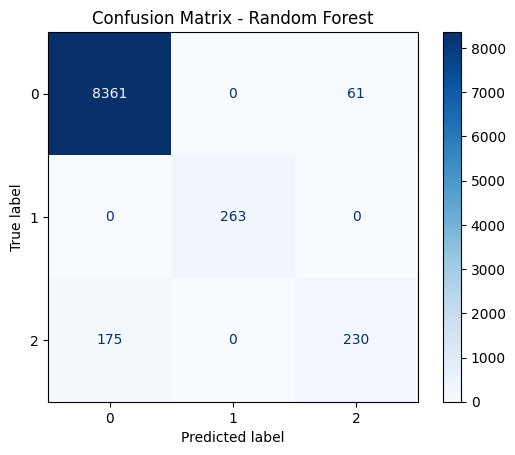

🎯 ROC AUC Score (macro-averaged OVR) for Random Forest: 0.9911

🔧 Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4059
[LightGBM] [Info] Number of data points in the train set: 36360, number of used features: 35
[LightGBM] [Info] Start training from score -0.076417
[LightGBM] [Info] Start training from score -3.541826
[LightGBM] [Info] Start training from score -3.109809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

📊 Classification Report for LightGBM:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      8422
           1       1.00      1.00      1.00       263
           2       0.81      0.62      0.70       405

    accuracy                           0.98      9090
   macro avg       0.93      0.87      0.90      9090
weighted avg       0.

/home/gemitry/Projects/pdm-b7/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/gemitry/Projects/pdm-b7/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


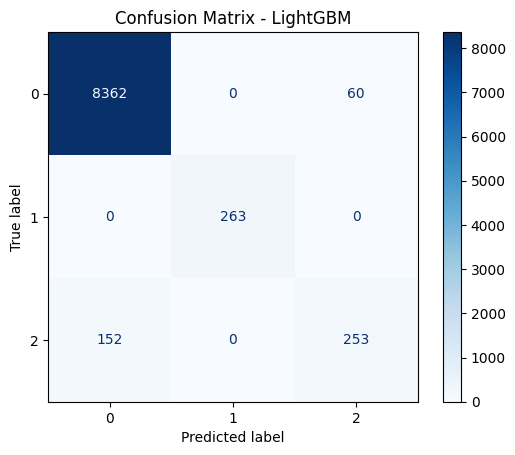

🎯 ROC AUC Score (macro-averaged OVR) for LightGBM: 0.9925

🔧 Training XGBoost...

📊 Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      8422
           1       1.00      1.00      1.00       263
           2       0.77      0.59      0.67       405

    accuracy                           0.97      9090
   macro avg       0.92      0.86      0.88      9090
weighted avg       0.97      0.97      0.97      9090



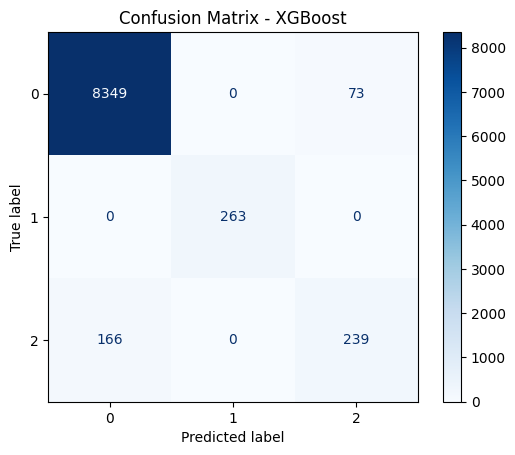

🎯 ROC AUC Score (macro-averaged OVR) for XGBoost: 0.9915


/home/gemitry/Projects/pdm-b7/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/gemitry/Projects/pdm-b7/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/gemitry/Projects/pdm-b7/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/gemitry/Projects/pdm-b7/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/gemitry/Projects/pdm-b7/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featur

,Model,ROC AUC Score,F1-Score,Accuracy,Precision,Recall
0,Random Forest,0.991143,0.882334,0.974037,0.923292,0.853553
1,LightGBM,0.992471,0.897406,0.976678,0.930151,0.872522
2,XGBoost,0.991472,0.884185,0.973707,0.915510,0.860485


In [4]:
X = df.drop(columns=["Condition", "times"])
y = df["Condition"]

numeric_cols = [
    'Suhu Sealing Vertikal Bawah (oC)',
    'Suhu Sealing Vertical Atas (oC)',
    'Suhu Sealing Horizontal Depan/Kanan (oC)',
    'Suhu Sealing Horizontal Belakang/Kiri (oC )', 'Counter Output (pack)',
    'Counter Reject (pack)', 'Speed(rpm)',
    'Availability(%)', 'Performance(%)', 'Quality(%)', 'OEE(%)', 'Downtime_sec',
    'Output Time_sec', 'Total Time_sec', 'delta_Output Time_sec',
    'delta_Total Time_sec', 'delta_reject', 'day', 'hour',
    'minute', 'diff_sealing_vertical', 'diff_sealing_horizontal'
]

categorical_cols = [
    'Shift', 'Status', 'Jaws Position',
    'Doser Drive Enable', 'Sealing Enable', 'Machine Alarm'
]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numeric_cols),
        ('cat', cat_pipeline, categorical_cols)
    ]
)

# Transform the training and testing data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Compare different models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, objective="multiclass"),
    "XGBoost": XGBClassifier(random_state=42),
}

# Binarize target for ROC AUC
class_labels = np.unique(y)
y_test_bin = label_binarize(y_test, classes=class_labels)

# Train and evaluate each model
for name, model in models.items():
    print(f"\n🔧 Training {name}...")
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    # Classification report
    print(f"\n📊 Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # ROC AUC Score
    y_test_bin = label_binarize(y_test, classes=class_labels)
    roc_auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr', average='macro')
    print(f"🎯 ROC AUC Score (macro-averaged OVR) for {name}: {roc_auc:.4f}")

# Summary
df_model_summary = pd.DataFrame({
    "Model": list(models.keys()),
    "ROC AUC Score": [roc_auc_score(label_binarize(y_test, classes=np.unique(y)), model.predict_proba(X_test), multi_class='ovr', average='macro') for model in models.values()],
    "F1-Score": [classification_report(y_test, model.predict(X_test), output_dict=True)['macro avg']['f1-score'] for model in models.values()],
    "Accuracy": [model.score(X_test, y_test) for model in models.values()],
    "Precision": [classification_report(y_test, model.predict(X_test), output_dict=True)['macro avg']['precision'] for model in models.values()],
    "Recall": [classification_report(y_test, model.predict(X_test), output_dict=True)['macro avg']['recall'] for model in models.values()]
})

df_model_summary

## Directional LSTM

In [5]:
# Create Windows / Sequences for LSTM
def create_sequences(data, labels, window_size=5):
    sequences = []
    sequence_labels = []
    
    for i in range(len(data) - window_size):
        seq = data[i:i + window_size]
        label = labels[i + window_size - 1]
        sequences.append(seq)
        sequence_labels.append(label)
    
    return np.array(sequences), np.array(sequence_labels)

# Reset index dulu
X_train = pd.DataFrame(X_train).reset_index(drop=True)
X_test = pd.DataFrame(X_test).reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

# Convert ke array
X_train_seq, y_train_seq = create_sequences(X_train.values, y_train.values, window_size=5)
X_test_seq, y_test_seq = create_sequences(X_test.values, y_test.values, window_size=5)

# One-hot encode labels
from tensorflow.keras.utils import to_categorical
y_train_seq = to_categorical(y_train_seq, num_classes=len(np.unique(y)))
y_test_seq = to_categorical(y_test_seq, num_classes=len(np.unique(y)))

# Model
lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(len(np.unique(y)), activation='softmax')
])

lstm.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=["accuracy"]
)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training
lstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


W0000 00:00:1751337106.264852   15455 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/gemitry/Projects/pdm-b7/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - accuracy: 0.9277 - loss: 0.2743 - val_accuracy: 0.9552 - val_loss: 0.1318
Epoch 2/50
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9536 - loss: 0.1330 - val_accuracy: 0.9572 - val_loss: 0.1192
Epoch 3/50
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9560 - loss: 0.1209 - val_accuracy: 0.9577 - val_loss: 0.1164
Epoch 4/50
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.9572 - loss: 0.1144 - val_accuracy: 0.9582 - val_loss: 0.1103
Epoch 5/50
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.9594 - loss: 0.1030 - val_accuracy: 0.9606 - val_loss: 0.1063
Epoch 6/50
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.9585 - loss: 0.1040 - val_accuracy: 0.9609 - val_loss: 0.1035
Epoch 7/50
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.9614 - loss: 0.0961 - val_accuracy: 0.9607 - val_loss: 0.0983
Epoch 8/50
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9645 -

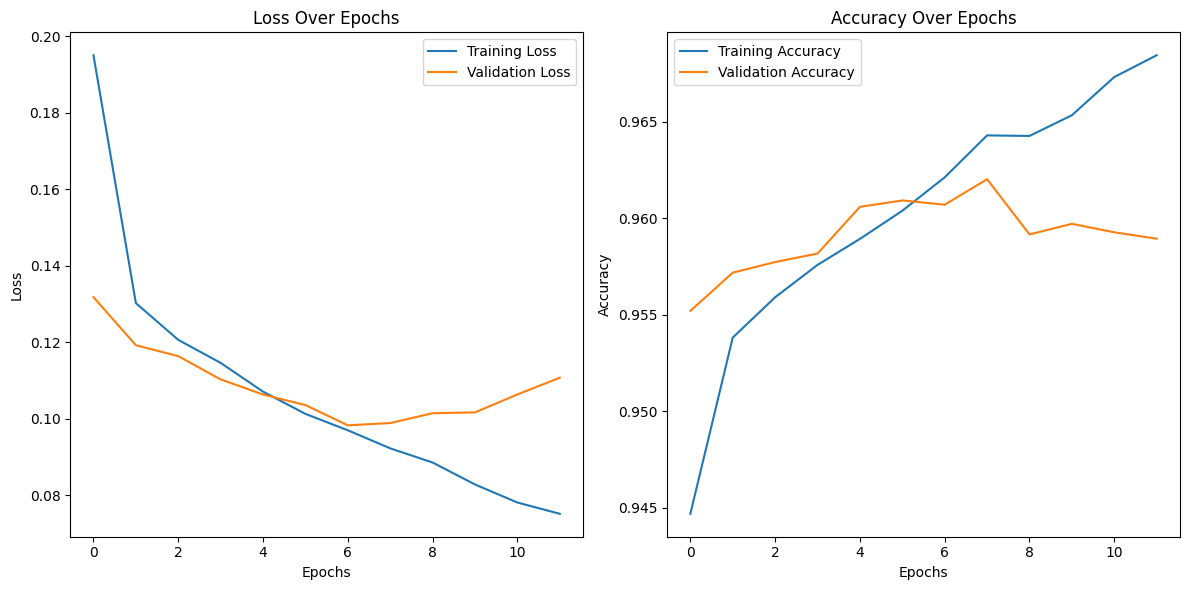

In [6]:
history = lstm.history.history
# Plotting training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

📊 Classification Report for lstm:

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      8418
           1       1.00      1.00      1.00       262
           2       0.66      0.25      0.36       405

    accuracy                           0.96      9085
   macro avg       0.87      0.75      0.78      9085
weighted avg       0.95      0.96      0.95      9085



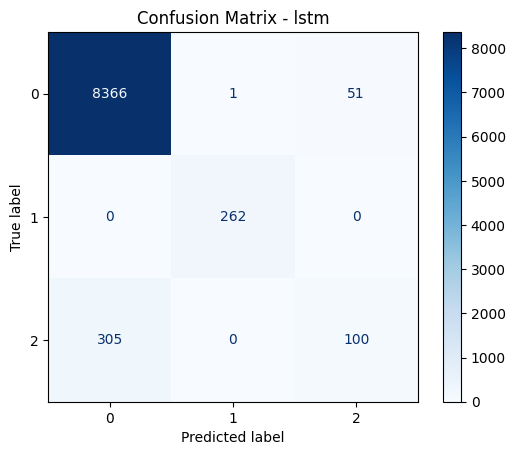

🎯 ROC AUC Score (macro-averaged OVR) for LSTM: 0.9742


In [7]:
# Eval the model
y_pred_seq = lstm.predict(X_test_seq)
y_pred_labels = np.argmax(y_pred_seq, axis=1)
y_test_labels = np.argmax(y_test_seq, axis=1)

# Classification report
print("\n📊 Classification Report for lstm:\n")
print(classification_report(y_test_labels, y_pred_labels))
# Confusion matrix
cm_seq = confusion_matrix(y_test_labels, y_pred_labels, labels=np.unique(y))
disp_seq = ConfusionMatrixDisplay(confusion_matrix=cm_seq, display_labels=np.unique(y))
disp_seq.plot(cmap="Blues")
plt.title("Confusion Matrix - lstm")
plt.show()
# ROC AUC Score for lstm
y_test_seq_bin = label_binarize(y_test_labels, classes=np.unique(y))
roc_auc_seq = roc_auc_score(y_test_seq_bin, y_pred_seq, multi_class='ovr', average='macro')
print(f"🎯 ROC AUC Score (macro-averaged OVR) for LSTM: {roc_auc_seq:.4f}")
# Summary for lstm
df_lstm_summary = pd.DataFrame({
    "Model": ["lstm"],
    "ROC AUC Score": [roc_auc_seq],
    "F1-Score": [classification_report(y_test_labels, y_pred_labels, output_dict=True)['macro avg']['f1-score']],
    "Accuracy": [np.mean(y_test_labels == y_pred_labels)],
    "Precision": [classification_report(y_test_labels, y_pred_labels, output_dict=True)['macro avg']['precision']],
    "Recall": [classification_report(y_test_labels, y_pred_labels, output_dict=True)['macro avg']['recall']]
})

In [8]:
df_model_summary = pd.concat([df_model_summary, df_lstm_summary], ignore_index=True)

In [9]:
df_model_summary

,Model,ROC AUC Score,F1-Score,Accuracy,Precision,Recall
0,Random Forest,0.991143,0.882334,0.974037,0.923292,0.853553
1,LightGBM,0.992471,0.897406,0.976678,0.930151,0.872522
2,XGBoost,0.991472,0.884185,0.973707,0.915510,0.860485
3,lstm,0.974201,0.778972,0.960704,0.874425,0.746912
